In [30]:
from Utils.ConfigProvider import ConfigProvider
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
config = ConfigProvider.config()
%matplotlib inline
%load_ext autoreload
%autoreload 2

Enter config
Leave config
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Let’s look at the data


<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'inspected')

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'reference')

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'diff')

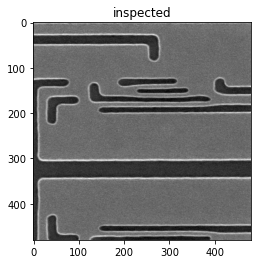

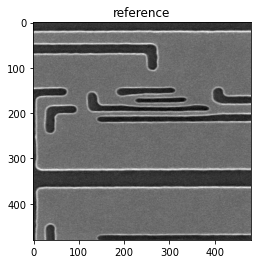

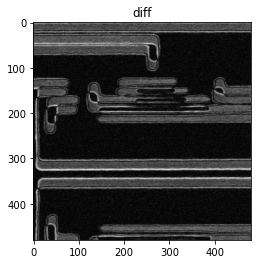

In [31]:
inspected = cv2.imread(config.data.non_defective_inspected_path, 0)
reference = cv2.imread(config.data.non_defective_reference_path, 0)

# inspected = cv2.imread(config.data.inspected_image_path, 0)
# reference = cv2.imread(config.data.reference_image_path, 0)
diff = np.abs(np.array(inspected, dtype=np.int) - np.array(reference, dtype=np.int))

plt.figure()
plt.title('inspected')
plt.imshow(inspected, cmap='gray')
plt.figure()
plt.title('reference')
plt.imshow(reference, cmap='gray')
plt.figure()
plt.title('diff')
plt.imshow(diff, cmap='gray')

plt.show()

Looks like light noise, and some displacement (like we already knew)

Fight the noise:

Enter config
Leave config


<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'r_clean')

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'i_clean')

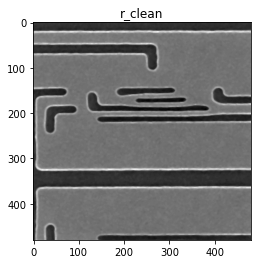

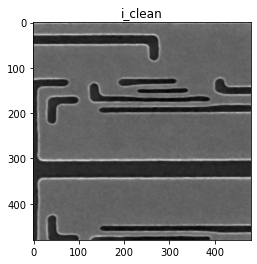

In [32]:
from noise_cleaning.NoiseCleaner import NoiseCleaner
noise_cleaner = NoiseCleaner()
r_clean = noise_cleaner.clean_salt_and_pepper(reference)
i_clean = noise_cleaner.clean_salt_and_pepper(inspected)
# want edge preservation, so no gaussian blur
# r_clean = noise_cleaner.blur(reference)
# i_clean = noise_cleaner.blur(inspected)

plt.figure()
plt.title('r_clean')
plt.imshow(r_clean, cmap='gray')
plt.figure()
plt.title('i_clean')
plt.imshow(i_clean, cmap='gray')

Fight the displacement with simple feature based alignment.
(since the images are pretty close and not rotated, area based registration could be better, but less robust)



Enter config
Leave config
forcing tform [[  1.           0.          10.2159107 ]
 [  0.           1.         -17.00309463]
 [  0.           0.           1.        ]] to translation only
tform: [[  1.           0.          10.2159107 ]
 [  0.           1.         -17.00309463]
 [  0.           0.           1.        ]]


<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'matches_image')

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'warped')

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'warped_diff')

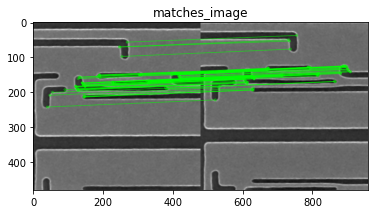

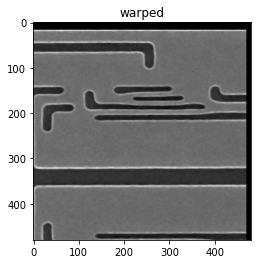

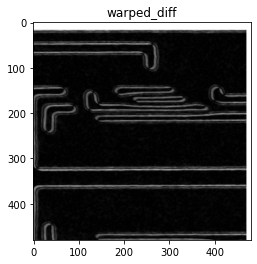

In [33]:
from alignment.Aligner import Aligner
aligner = Aligner()
matches_image, warped, tform, warped_mask = aligner.align_using_feature_matching(static=r_clean, moving=i_clean)
print(f"tform: {tform}")

plt.figure()
plt.title('matches_image')
plt.imshow(matches_image, cmap='gray')
plt.figure()
plt.title('warped')
plt.imshow(warped, cmap='gray')

warped_diff = np.ones(inspected.shape) * 255
warped_diff[warped_mask] = np.array(warped, dtype=np.int)[warped_mask]
warped_diff[warped_mask] -= np.array(r_clean, dtype=np.int)[warped_mask]
warped_diff = np.array(np.abs(warped_diff), dtype=np.uint8)
plt.figure()
plt.title('warped_diff')
plt.imshow(warped_diff, cmap='gray')


By looking at the tform matrix directly, we can see the tform is almost only a translation (good).
We also see that the noise in the (cleaned) images will make a direct subtraction ineffective.

Let's segment the reference image, then apply the segmentaion to the warped image,
and check the probability of each pixel based on its neighbourhood
which is also inside its segment

First, let's see the histogram, to see if thresholding is any good, and which to choose

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'intersection_diff')

(array([6.0000e+00, 0.0000e+00, 2.0000e+00, 4.0000e+00, 5.0000e+00,
        1.7000e+01, 3.1000e+01, 3.4000e+01, 3.1000e+01, 3.0000e+01,
        4.0000e+01, 5.7000e+01, 5.2000e+01, 5.7000e+01, 3.7000e+01,
        4.3000e+01, 4.8000e+01, 6.8000e+01, 1.0600e+02, 1.0300e+02,
        1.3800e+02, 1.4700e+02, 1.6900e+02, 2.2600e+02, 2.1200e+02,
        2.1600e+02, 2.7800e+02, 2.9400e+02, 2.5100e+02, 4.2700e+02,
        5.0700e+02, 5.5700e+02, 5.7300e+02, 5.8900e+02, 6.2400e+02,
        5.7000e+02, 4.9900e+02, 4.4500e+02, 4.0700e+02, 3.3000e+02,
        3.8600e+02, 3.7300e+02, 2.3100e+02, 3.9100e+02, 4.6700e+02,
        4.6800e+02, 4.9700e+02, 4.9400e+02, 4.7600e+02, 5.0000e+02,
        4.8800e+02, 5.1100e+02, 5.4100e+02, 6.1000e+02, 6.7100e+02,
        7.1100e+02, 4.4700e+02, 7.1900e+02, 7.1000e+02, 7.9900e+02,
        9.6700e+02, 9.6500e+02, 1.0480e+03, 1.3790e+03, 2.3870e+03,
        5.9330e+03, 1.6422e+04, 4.9555e+04, 4.8525e+04, 3.5803e+04,
        1.6007e+04, 4.1560e+03, 3.2370e+03, 1.99

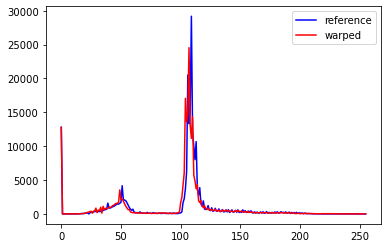

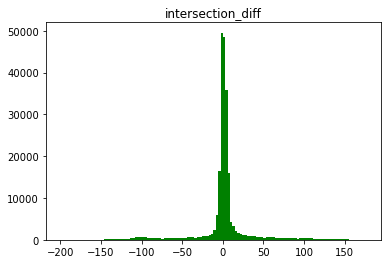

In [51]:
r_intersection = r_clean
r_intersection[~warped_mask] = 0
warped_intersection = warped
warped[~warped_mask] = 0

r_clean_hist = cv2.calcHist([r_intersection], [0], None, [256], [0, 256])
w_clean_hist = cv2.calcHist([warped_intersection], [0], None, [256], [0, 256])
plt.figure()
plt.plot(r_clean_hist, color='b', label='reference')
plt.plot(w_clean_hist, color='r', label='warped')
plt.legend()

intersection_diff = np.array(r_intersection, dtype=np.int) - np.array(warped_intersection, dtype=np.int)
plt.figure()
plt.title('intersection_diff')
plt.hist(intersection_diff.ravel(), bins=128, color='green', label='intersection_diff_hist')
plt.show()


We see two distinct pixel intensities, and a "leak" towards the high end of the histogram,
which would account for the white edges, as there are not many of them.

In [35]:
from segmentation.Segmenter import Segmenter
segmenter = Segmenter()
r_segmentation = segmenter.segment_image(reference)

Enter config
Leave config


AttributeError: 'NoneType' object has no attribute 'num_classes'

# plt.figure()
# plt.title('r_edges')
# plt.imshow(r_edges, cmap='gray')